In [1]:
import os
import pandas as pd
import numpy as np
import warnings
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,OneHotEncoder, MinMaxScaler,normalize
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
from catboost import CatBoostClassifier

%matplotlib inline
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']

In [2]:
df1=pd.read_csv('test_set.csv')
df=df1['ID']
df=pd.DataFrame(df)
df['hepatitis']=0
df.head()

,ID,hepatitis
0,7964,0
1,7320,0
2,2114,0
3,2443,0
4,473,0


In [3]:
train_df = pd.read_csv('train_set.csv') 
test_df  = pd.read_csv('test_set.csv') 
submission  =  df
print('Train Shape:{}\nTest Shape:{}'.format(train_df.shape,test_df.shape))
train_df.head()

Train Shape:(6000, 31)
Test Shape:(2785, 30)


,年龄,性别,区域,体重,身高,体重指数,肥胖腰围,腰围,最高血压,最低血压,好胆固醇,坏胆固醇,总胆固醇,血脂异常,PVD,体育活动,教育,未婚,收入,护理来源,视力不佳,饮酒,高血压,家庭高血压,糖尿病,家族糖尿病,肝炎,家族肝炎,慢性疲劳,ALF,ID
0,58,F,east,75.6,174.9,24.71,0.0,94.8,100.0,52.0,35.0,95.0,130.0,0,0,1.0,0.0,0.0,0.0,Private Hospital,0.0,0,1.0,1,0.0,1,1.0,0.0,1.0,0.0,4379
1,85,F,east,66.3,166.1,24.03,0.0,89.6,134.0,84.0,59.0,153.0,212.0,0,0,2.0,0.0,0.0,0.0,Private Hospital,0.0,1,0.0,0,0.0,0,0.0,0.0,0.0,NaN,7623
2,32,F,east,109.9,173.2,36.64,1.0,111.7,124.0,84.0,39.0,133.0,172.0,0,0,2.0,1.0,0.0,1.0,Private Hospital,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,1764
3,22,M,east,58.7,171.3,20.00,0.0,78.0,104.0,56.0,48.0,98.0,146.0,0,0,2.0,1.0,1.0,0.0,Never Counsulted,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,5450
4,44,F,west,79.7,172.1,26.91,0.0,93.8,114.0,60.0,34.0,195.0,229.0,0,0,2.0,0.0,0.0,0.0,Private Hospital,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,5196


In [4]:
train_df.describe()

,年龄,体重,身高,体重指数,肥胖腰围,腰围,最高血压,最低血压,好胆固醇,坏胆固醇,总胆固醇,血脂异常,PVD,体育活动,教育,未婚,收入,视力不佳,饮酒,高血压,家庭高血压,糖尿病,家族糖尿病,肝炎,家族肝炎,慢性疲劳,ALF,ID
count,6000.000000,5860.000000,5864.000000,5791.000000,5791.000000,5776.000000,5781.000000,5727.000000,5994.000000,5993.000000,5993.000000,6000.000000,6000.00000,5992.000000,5986.000000,5692.000000,5237.000000,5598.000000,6000.000000,5951.000000,6000.000000,6000.000000,6000.000000,5984.000000,5995.000000,5974.000000,4119.000000,6000.000000
mean,49.331000,79.140884,167.037142,28.306374,0.317044,96.837846,125.582944,71.469356,51.627794,152.999166,204.628066,0.105833,0.04150,2.017190,0.434347,0.366831,0.418178,0.065916,0.301000,0.401613,0.239500,0.110333,0.314500,0.067179,0.020684,0.031637,0.074775,4362.312833
std,18.784868,19.293747,10.124373,6.136871,0.465365,14.928330,21.004949,12.663285,15.518744,42.745425,42.707270,0.307650,0.19946,0.812113,0.495712,0.481982,0.493307,0.248158,0.458731,0.490266,0.426814,0.313331,0.464355,0.250353,0.142336,0.175047,0.263061,2538.515901
min,20.000000,33.700000,130.400000,14.420000,0.000000,58.600000,72.000000,10.000000,12.000000,27.000000,72.000000,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,33.000000,65.600000,159.700000,24.080000,0.000000,86.300000,111.000000,64.000000,41.000000,124.000000,176.000000,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2142.750000
50%,47.000000,76.700000,166.600000,27.390000,0.000000,96.300000,122.000000,72.000000,49.000000,150.000000,201.000000,0.000000,0.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4363.500000
75%,65.000000,89.525000,174.200000,31.390000,1.000000,106.100000,136.000000,79.000000,60.000000,178.000000,230.000000,0.000000,0.00000,2.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,6558.250000
max,85.000000,191.100000,200.100000,66.440000,1.000000,166.000000,233.000000,132.000000,160.000000,684.000000,727.000000,1.000000,1.00000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8784.000000


In [5]:
train_df.columns

Index(['年龄', '性别', '区域', '体重', '身高', '体重指数', '肥胖腰围', '腰围', '最高血压', '最低血压',
       '好胆固醇', '坏胆固醇', '总胆固醇', '血脂异常', 'PVD', '体育活动', '教育', '未婚', '收入', '护理来源',
       '视力不佳', '饮酒', '高血压', '家庭高血压', '糖尿病', '家族糖尿病', '肝炎', '家族肝炎', '慢性疲劳',
       'ALF', 'ID'],
      dtype='object')

In [6]:
num_columns = ['年龄','体重','身高','体重指数', '腰围', '最高血压', '最低血压',
                '好胆固醇', '坏胆固醇', '总胆固醇','收入']
zero_to_one_columns = ['肥胖腰围','血脂异常','PVD']
str_columns = ['性别','区域','体育活动','教育','未婚','护理来源','视力不佳','饮酒','高血压',
                '家庭高血压', '糖尿病', '家族糖尿病','家族肝炎', '慢性疲劳','ALF']

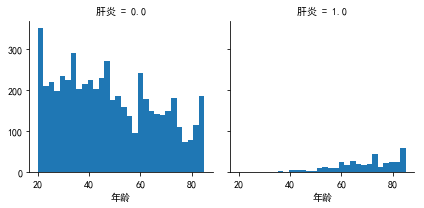

In [7]:
g = sns.FacetGrid(train_df, col='肝炎')
g.map(plt.hist, '年龄', bins=30)

In [8]:
#train_df=train_df[~train_df['肝炎'].isnull()]
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 31 columns):
年龄       6000 non-null int64
性别       6000 non-null object
区域       6000 non-null object
体重       5860 non-null float64
身高       5864 non-null float64
体重指数     5791 non-null float64
肥胖腰围     5791 non-null float64
腰围       5776 non-null float64
最高血压     5781 non-null float64
最低血压     5727 non-null float64
好胆固醇     5994 non-null float64
坏胆固醇     5993 non-null float64
总胆固醇     5993 non-null float64
血脂异常     6000 non-null int64
PVD      6000 non-null int64
体育活动     5992 non-null float64
教育       5986 non-null float64
未婚       5692 non-null float64
收入       5237 non-null float64
护理来源     6000 non-null object
视力不佳     5598 non-null float64
饮酒       6000 non-null int64
高血压      5951 non-null float64
家庭高血压    6000 non-null int64
糖尿病      6000 non-null float64
家族糖尿病    6000 non-null int64
肝炎       5984 non-null float64
家族肝炎     5995 non-null float64
慢性疲劳     5974 non-null float64
ALF      

# 数据处理

In [9]:
## 对于数值型变量的缺失值用平均数进行填充
feature1 = ['最低血压','腰围','最高血压','体重指数','肥胖腰围','身高','体重','好胆固醇','总胆固醇','坏胆固醇']
for i in feature1:
    train_df[i] = train_df[i].fillna(train_df[i].mean())
## 对于分类型变量的缺失值用众数进行填充
feature2 = ['收入','未婚','视力不佳','高血压','慢性疲劳','教育','糖尿病','ALF','体育活动','家族肝炎','肝炎']
for j in feature2:
    train_df[j] = train_df[j].fillna(train_df[j].mode()[0]) 
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 31 columns):
年龄       6000 non-null int64
性别       6000 non-null object
区域       6000 non-null object
体重       6000 non-null float64
身高       6000 non-null float64
体重指数     6000 non-null float64
肥胖腰围     6000 non-null float64
腰围       6000 non-null float64
最高血压     6000 non-null float64
最低血压     6000 non-null float64
好胆固醇     6000 non-null float64
坏胆固醇     6000 non-null float64
总胆固醇     6000 non-null float64
血脂异常     6000 non-null int64
PVD      6000 non-null int64
体育活动     6000 non-null float64
教育       6000 non-null float64
未婚       6000 non-null float64
收入       6000 non-null float64
护理来源     6000 non-null object
视力不佳     6000 non-null float64
饮酒       6000 non-null int64
高血压      6000 non-null float64
家庭高血压    6000 non-null int64
糖尿病      6000 non-null float64
家族糖尿病    6000 non-null int64
肝炎       6000 non-null float64
家族肝炎     6000 non-null float64
慢性疲劳     6000 non-null float64
ALF      

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 31 columns):
年龄       6000 non-null int64
性别       6000 non-null object
区域       6000 non-null object
体重       6000 non-null float64
身高       6000 non-null float64
体重指数     6000 non-null float64
肥胖腰围     6000 non-null float64
腰围       6000 non-null float64
最高血压     6000 non-null float64
最低血压     6000 non-null float64
好胆固醇     6000 non-null float64
坏胆固醇     6000 non-null float64
总胆固醇     6000 non-null float64
血脂异常     6000 non-null int64
PVD      6000 non-null int64
体育活动     6000 non-null float64
教育       6000 non-null float64
未婚       6000 non-null float64
收入       6000 non-null float64
护理来源     6000 non-null object
视力不佳     6000 non-null float64
饮酒       6000 non-null int64
高血压      6000 non-null float64
家庭高血压    6000 non-null int64
糖尿病      6000 non-null float64
家族糖尿病    6000 non-null int64
肝炎       6000 non-null float64
家族肝炎     6000 non-null float64
慢性疲劳     6000 non-null float64
ALF      

In [11]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2785 entries, 0 to 2784
Data columns (total 30 columns):
年龄       2785 non-null int64
性别       2785 non-null object
区域       2785 non-null object
体重       2731 non-null float64
身高       2730 non-null float64
体重指数     2704 non-null float64
肥胖腰围     2704 non-null float64
腰围       2695 non-null float64
最高血压     2700 non-null float64
最低血压     2682 non-null float64
好胆固醇     2774 non-null float64
坏胆固醇     2774 non-null float64
总胆固醇     2776 non-null float64
血脂异常     2785 non-null int64
PVD      2785 non-null int64
体育活动     2783 non-null float64
教育       2779 non-null float64
未婚       2641 non-null float64
收入       2387 non-null float64
护理来源     2785 non-null object
视力不佳     2624 non-null float64
饮酒       2785 non-null int64
高血压      2754 non-null float64
家庭高血压    2785 non-null int64
糖尿病      2783 non-null float64
家族糖尿病    2785 non-null int64
家族肝炎     2784 non-null float64
慢性疲劳     2776 non-null float64
ALF      1881 non-null float64
ID       

In [12]:
feature1 = ['最低血压','腰围','最高血压','体重指数','肥胖腰围','身高','体重','好胆固醇','总胆固醇','坏胆固醇']
for i in feature1:
    test_df[i] = test_df[i].fillna(test_df[i].mean())
## 对于分类型变量的缺失值用众数进行填充
feature2 = ['收入','未婚','视力不佳','高血压','慢性疲劳','教育','糖尿病','ALF','体育活动','家族肝炎']
for j in feature2:
    test_df[j] = test_df[j].fillna(test_df[j].mode()[0]) 
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2785 entries, 0 to 2784
Data columns (total 30 columns):
年龄       2785 non-null int64
性别       2785 non-null object
区域       2785 non-null object
体重       2785 non-null float64
身高       2785 non-null float64
体重指数     2785 non-null float64
肥胖腰围     2785 non-null float64
腰围       2785 non-null float64
最高血压     2785 non-null float64
最低血压     2785 non-null float64
好胆固醇     2785 non-null float64
坏胆固醇     2785 non-null float64
总胆固醇     2785 non-null float64
血脂异常     2785 non-null int64
PVD      2785 non-null int64
体育活动     2785 non-null float64
教育       2785 non-null float64
未婚       2785 non-null float64
收入       2785 non-null float64
护理来源     2785 non-null object
视力不佳     2785 non-null float64
饮酒       2785 non-null int64
高血压      2785 non-null float64
家庭高血压    2785 non-null int64
糖尿病      2785 non-null float64
家族糖尿病    2785 non-null int64
家族肝炎     2785 non-null float64
慢性疲劳     2785 non-null float64
ALF      2785 non-null float64
ID       

In [13]:
# 字符编码
for i in tqdm(str_columns):
    lbl = LabelEncoder()
    train_df[i] = lbl.fit_transform(train_df[i].astype(str))
    test_df[i]  = lbl.fit_transform(test_df[i].astype(str))

100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 254.73it/s]


In [14]:
# 数值归一化
train_df[num_columns] = MinMaxScaler().fit_transform(train_df[num_columns])
test_df[num_columns]  = MinMaxScaler().fit_transform(test_df[num_columns])

#标准化
from sklearn import preprocessing 
scaler = preprocessing.StandardScaler()
train_df[num_columns] = scaler.fit_transform(train_df[num_columns])
test_df[num_columns]=scaler.fit_transform(test_df[num_columns])

In [15]:
all_columns = [i for i in train_df.columns if i not in ['肝炎','ID']]

train_x,train_y = train_df[all_columns].values,train_df['肝炎'].values
test_x  = test_df[all_columns].values
submission['hepatitis'] = 0

# LightBoost

In [16]:
import lightgbm as lgb
kfold = StratifiedKFold(n_splits=2, shuffle=False)

model=lgb.LGBMClassifier(boosting_type='gbdt',
                         objective='binary',
                         metrics='auc',
                        learning_rate=0.00064, 
                         n_estimators=1000,
                         max_depth=4, 
                         num_leaves=24,
                         max_bin=40,
                         min_data_in_leaf=18,
                         bagging_fraction=0.6,
                         bagging_freq= 0, 
                         feature_fraction=0.6,
                         lambda_l1=0.01,
                         lambda_l2=0.15,
                         min_split_gain=0.7)

for train, valid in kfold.split(train_x, train_y):
    X_train, Y_train = train_x[train], train_y[train]
    X_valid, Y_valid = train_x[valid], train_y[valid]
    model.fit(X_train,Y_train, eval_set=(X_valid, Y_valid))
    Y_valid_pred_prob = model.predict_proba(X_valid)
    submission['hepatitis'] += model.predict_proba(test_x)[:,1] / 5

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=0.15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.15
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[1]	valid_0's auc: 0.82665
[2]	valid_0's auc: 0.835273
[3]	valid_0's auc: 0.845733
[4]	valid_0's auc: 0.843252
[5]	valid_0's auc: 0.844705
[6]	valid_0's auc: 0.849607
[7]	valid_0's auc: 0.850806
[8]	valid_0's auc: 0.852202
[9]	valid_0's auc: 0.853494
[10]	valid_0's auc: 0.853563
[11]	valid_0's auc: 0.855469
[12]	vali

[303]	valid_0's auc: 0.857005
[304]	valid_0's auc: 0.857003
[305]	valid_0's auc: 0.856998
[306]	valid_0's auc: 0.856953
[307]	valid_0's auc: 0.85696
[308]	valid_0's auc: 0.857028
[309]	valid_0's auc: 0.857081
[310]	valid_0's auc: 0.857117
[311]	valid_0's auc: 0.857079
[312]	valid_0's auc: 0.857047
[313]	valid_0's auc: 0.857042
[314]	valid_0's auc: 0.857072
[315]	valid_0's auc: 0.857015
[316]	valid_0's auc: 0.857079
[317]	valid_0's auc: 0.857085
[318]	valid_0's auc: 0.857101
[319]	valid_0's auc: 0.857163
[320]	valid_0's auc: 0.857204
[321]	valid_0's auc: 0.857243
[322]	valid_0's auc: 0.857229
[323]	valid_0's auc: 0.857214
[324]	valid_0's auc: 0.85723
[325]	valid_0's auc: 0.857225
[326]	valid_0's auc: 0.857277
[327]	valid_0's auc: 0.85727
[328]	valid_0's auc: 0.857282
[329]	valid_0's auc: 0.857214
[330]	valid_0's auc: 0.857195
[331]	valid_0's auc: 0.85719
[332]	valid_0's auc: 0.857165
[333]	valid_0's auc: 0.85739
[334]	valid_0's auc: 0.85741
[335]	valid_0's auc: 0.857447
[336]	valid_0's 

[643]	valid_0's auc: 0.858668
[644]	valid_0's auc: 0.858656
[645]	valid_0's auc: 0.858709
[646]	valid_0's auc: 0.858725
[647]	valid_0's auc: 0.858713
[648]	valid_0's auc: 0.858695
[649]	valid_0's auc: 0.858681
[650]	valid_0's auc: 0.858663
[651]	valid_0's auc: 0.858654
[652]	valid_0's auc: 0.858585
[653]	valid_0's auc: 0.858555
[654]	valid_0's auc: 0.858567
[655]	valid_0's auc: 0.858583
[656]	valid_0's auc: 0.858615
[657]	valid_0's auc: 0.858585
[658]	valid_0's auc: 0.858585
[659]	valid_0's auc: 0.858663
[660]	valid_0's auc: 0.858683
[661]	valid_0's auc: 0.858645
[662]	valid_0's auc: 0.858628
[663]	valid_0's auc: 0.858622
[664]	valid_0's auc: 0.858628
[665]	valid_0's auc: 0.858601
[666]	valid_0's auc: 0.858592
[667]	valid_0's auc: 0.858587
[668]	valid_0's auc: 0.858578
[669]	valid_0's auc: 0.858569
[670]	valid_0's auc: 0.858606
[671]	valid_0's auc: 0.85859
[672]	valid_0's auc: 0.85861
[673]	valid_0's auc: 0.858613
[674]	valid_0's auc: 0.858677
[675]	valid_0's auc: 0.858711
[676]	valid_

[978]	valid_0's auc: 0.858473
[979]	valid_0's auc: 0.858475
[980]	valid_0's auc: 0.858496
[981]	valid_0's auc: 0.8585
[982]	valid_0's auc: 0.858523
[983]	valid_0's auc: 0.858521
[984]	valid_0's auc: 0.858551
[985]	valid_0's auc: 0.858528
[986]	valid_0's auc: 0.858533
[987]	valid_0's auc: 0.858533
[988]	valid_0's auc: 0.858539
[989]	valid_0's auc: 0.858549
[990]	valid_0's auc: 0.858583
[991]	valid_0's auc: 0.858596
[992]	valid_0's auc: 0.858565
[993]	valid_0's auc: 0.85861
[994]	valid_0's auc: 0.85862
[995]	valid_0's auc: 0.85862
[996]	valid_0's auc: 0.858644
[997]	valid_0's auc: 0.858636
[998]	valid_0's auc: 0.858642
[999]	valid_0's auc: 0.858628
[1000]	valid_0's auc: 0.858644
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ig

[299]	valid_0's auc: 0.866607
[300]	valid_0's auc: 0.866619
[301]	valid_0's auc: 0.866591
[302]	valid_0's auc: 0.866608
[303]	valid_0's auc: 0.866601
[304]	valid_0's auc: 0.866631
[305]	valid_0's auc: 0.866647
[306]	valid_0's auc: 0.866651
[307]	valid_0's auc: 0.866683
[308]	valid_0's auc: 0.866797
[309]	valid_0's auc: 0.866802
[310]	valid_0's auc: 0.866777
[311]	valid_0's auc: 0.866838
[312]	valid_0's auc: 0.866909
[313]	valid_0's auc: 0.866861
[314]	valid_0's auc: 0.866866
[315]	valid_0's auc: 0.866809
[316]	valid_0's auc: 0.866852
[317]	valid_0's auc: 0.866736
[318]	valid_0's auc: 0.866724
[319]	valid_0's auc: 0.866679
[320]	valid_0's auc: 0.866671
[321]	valid_0's auc: 0.866623
[322]	valid_0's auc: 0.866631
[323]	valid_0's auc: 0.866697
[324]	valid_0's auc: 0.866752
[325]	valid_0's auc: 0.866704
[326]	valid_0's auc: 0.866669
[327]	valid_0's auc: 0.866703
[328]	valid_0's auc: 0.866688
[329]	valid_0's auc: 0.866683
[330]	valid_0's auc: 0.866607
[331]	valid_0's auc: 0.866518
[332]	vali

[628]	valid_0's auc: 0.866198
[629]	valid_0's auc: 0.86621
[630]	valid_0's auc: 0.86618
[631]	valid_0's auc: 0.8662
[632]	valid_0's auc: 0.866171
[633]	valid_0's auc: 0.866155
[634]	valid_0's auc: 0.866189
[635]	valid_0's auc: 0.866157
[636]	valid_0's auc: 0.866139
[637]	valid_0's auc: 0.866132
[638]	valid_0's auc: 0.86613
[639]	valid_0's auc: 0.866098
[640]	valid_0's auc: 0.866118
[641]	valid_0's auc: 0.866148
[642]	valid_0's auc: 0.866123
[643]	valid_0's auc: 0.866111
[644]	valid_0's auc: 0.866139
[645]	valid_0's auc: 0.866111
[646]	valid_0's auc: 0.866123
[647]	valid_0's auc: 0.866105
[648]	valid_0's auc: 0.86613
[649]	valid_0's auc: 0.866114
[650]	valid_0's auc: 0.866109
[651]	valid_0's auc: 0.866084
[652]	valid_0's auc: 0.866061
[653]	valid_0's auc: 0.866082
[654]	valid_0's auc: 0.866027
[655]	valid_0's auc: 0.865999
[656]	valid_0's auc: 0.865983
[657]	valid_0's auc: 0.865972
[658]	valid_0's auc: 0.865935
[659]	valid_0's auc: 0.86596
[660]	valid_0's auc: 0.865986
[661]	valid_0's a

[959]	valid_0's auc: 0.865297
[960]	valid_0's auc: 0.865313
[961]	valid_0's auc: 0.86533
[962]	valid_0's auc: 0.865325
[963]	valid_0's auc: 0.865329
[964]	valid_0's auc: 0.865316
[965]	valid_0's auc: 0.865346
[966]	valid_0's auc: 0.865343
[967]	valid_0's auc: 0.865302
[968]	valid_0's auc: 0.865289
[969]	valid_0's auc: 0.86532
[970]	valid_0's auc: 0.865329
[971]	valid_0's auc: 0.865298
[972]	valid_0's auc: 0.865291
[973]	valid_0's auc: 0.865273
[974]	valid_0's auc: 0.865263
[975]	valid_0's auc: 0.865289
[976]	valid_0's auc: 0.865275
[977]	valid_0's auc: 0.865245
[978]	valid_0's auc: 0.865259
[979]	valid_0's auc: 0.865236
[980]	valid_0's auc: 0.865233
[981]	valid_0's auc: 0.865245
[982]	valid_0's auc: 0.86524
[983]	valid_0's auc: 0.865257
[984]	valid_0's auc: 0.865256
[985]	valid_0's auc: 0.865241
[986]	valid_0's auc: 0.865217
[987]	valid_0's auc: 0.865245
[988]	valid_0's auc: 0.865249
[989]	valid_0's auc: 0.865243
[990]	valid_0's auc: 0.865243
[991]	valid_0's auc: 0.865215
[992]	valid_0